# 실제 실습 진행 : MNIST 숫자 이미지 분류 프로젝트

참고 :
1. https://wikidocs.net/195593
2. https://chatgpt.com/share/c4dceb02-50a3-4c9c-b84a-02bf76bf327b



> ### CPU, GPU, NPU 구분(복습)

    CPU와 GPU는 데이터를 읽어들여 연산처리를 통해 답을 도출하는 기능을 수행하지만 둘의 구조나 역할은 매우 다르다.
    ALU(Arithmetic Logic Unit)의 개수에 따라 연산속도가 달라지는데, 일반적으로 GPU가 훨씬 더 많은 ALU를
    가진다.

    CPU는 직렬 처리에 최적화된 몇 개의 코어로 구성된 반면, GPU는 "병렬처리"용으로 설계된 수천 개의 소형이고 효율적인
    코어로 구성된다. CPU는 GPU보다 더 적은 코어를 가지지만 각각의 코어가 GPU의 소형 코어보다 더 강력한 컴퓨팅 파워를
    지닌다. 따라서 직렬 처리에 더 적합하다.

    반면 GPU는 CPU보다 코어 수는 많으나 각각의 코어가 CPU보다 더 성능이 낮기 때문에 병렬적인 작업(Parallel Task)에
    더 강점이 있다.

    결론적으로 CPU는 컴퓨터의 전반적인 작업을 처리하기에 용이하고 / GPU는 "복잡한 연산"을 전문적으로 처리하기에 용이하다.
    딥러닝 수행 시 학습해야 할 파라미터들이 기하급수적으로 많으므로 방대한 계산량이 필요하다. 이때 CPU에서는 데이터를 GPU로
    보내 연산을 진행하며, 효율적으로 작업을 수행할 수 있게 된다.

    + NPU(Neural Processing Unit)는 딥러닝 네트워크를 구성하는 각 Layer를 "실리콘 = 하드웨어적"으로 구현한 칩셋이다.
    따라서 NPU를 사용하는 딥러닝 모델은 GPU를 사용할 때와 같은 100퍼센트의 자유도를 가지고 네트워크를 구성할 수 없다.
    실리콘으로 구현한 뉴런은 칩 설계 시 정해져 있고, NPU에서 구현하지 않은 뉴런이 딥러닝 네트워크에 포함되어 있다면
    그 부분은 하드웨어 가속을 타지 못하고 CPU로 연산을 수행해야 하기 떄문에 그 만큼 NPU를 사용하는 이점이 약화될 수 있다.

    ++ 그럼에도 GPU의 가격은 매우 비싸기 때문에 + 전력 소모가 매우 크기 떄문에 + 휴대불가능하기 떄문에 초소형으로 제작가능한
    NPU들이 개발된 것이다. 예를 들어 애플의 A16 칩셋의 Neural Engine이 NPU에 해당한다. 딥러닝 추론은 NPU를 탑재한 말단
    장비에서 이뤄지고, NPU를 통해 구동하고자 하는 딥러닝 모델은 GPU를 탑재한 대형 서버에서 학습하는 것이 좋다.

    +++ TPU(Tensor. 런타임 유형 변경에 포함되어 있음)는 구글에서 제작한 NPU의 이름이다. 독자적인 아키텍처로 구성되어 있어
    NPU보다 빠른 병렬처리가 가능하다.


In [1]:
import torch
torch.cuda.is_available() # GPU를 사용하고 있는지 확인 가능(런타임 유형 변경 -> T4 GPU)

True

### 기본적으로 MNIST 데이터셋은 28 x 28 크기의 이미지 60,000의 학습 세트와 10,000개의 테스트 세트로 구성되어 있다.

- 손으로 쓴 숫자를 인식하는 이미지 분류 문제를 해결하는 데 사용된다.

- MNIST 데이터셋은 머신러닝 및 딥러닝 분야에서 알고리즘의 정확도와 성능을 측정하는 데 자주 사용된다.



## I. 기본 세팅

In [2]:
# Colab에 저장되어 있는 학습 세트 19,999개와 테스트 세트 9,999개의 MNIST 이미지 데이터 사용
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns # pyplot 라이브러리를 기반으로 한 데이터 시각화 라이브러리이다. 다양한 시각화 기능을 지원한다.

import glob # 디렉토리 내 파일들의 리스트 추출 시 사용
import IPython.display as ipd # IPython 커널에서 사용되는 display 함수를 제공한다. 이미지/오디오/비디오 표시 시 유용하다.

glob.glob('./**/*mnist*.*')

['./sample_data/mnist_train_small.csv', './sample_data/mnist_test.csv']

In [3]:
df = pd.read_csv('./sample_data/mnist_train_small.csv')
df_test = pd.read_csv('./sample_data/mnist_test.csv')

print("train data size :", df.shape, ", test data size :", df_test.shape)

train data size : (19999, 785) , test data size : (9999, 785)


> - 785 : 28 x 28 픽셀 크기의 이미지를 1차원 배열로 펼친 784개의 숫자(features)와 해당 이미지가 나타내는 숫자(label : 0 ~ 9)로 구성됨.

### I-1. Pandas dataframe(df)에서 첫 10 -> 20개의 이미지 및 레이블을 추출하여 imshow() 메소드를 활용하는 사용자 정의 함수 imshowZerotoNine 함수를 호출하여 이미지를 시각화함.

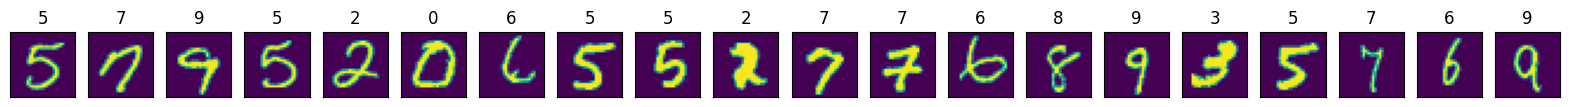

In [4]:
def imshowZerotoNine(imgs, labels):
    fig, axs = plt.subplots(1, 20, figsize = (20, 1)) # 10 -> 20으로 변경

    for i, ax in enumerate(axs.flat):
        ax.imshow(imgs.reshape(-1, 28, 28, 1)[i])
        ax.set_title(f"{labels[i]}")
        ax.set_xticks([])
        ax.set_yticks([])

def main():
    data = df.iloc[:20, 1:].to_numpy() # 첫 10 -> 20개 행의 첫 번째 열(label을 제외함)에서 끝 열까지의 데이터를 numpy array로 추출함.
    labels = df.iloc[:20, 0].to_numpy()
    imgs = data.reshape(-1, 28, 28, 1) # data 배열을 28 x 28 size의 이미지로 리턴하기 위해 reshape 함수를 이용한다.
    imshowZerotoNine(imgs, labels) # 변환된 이미지와 레이블을 기 정의한 함수에 인자로 전달, 이미지를 시각화한다.

if __name__ == "__main__":
    main()

## II. Dataset과 DataLoader 만들기



In [5]:
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T

"""

    - 클래스 생성자에서는 데이터프레임을 입력으로 받아 self.df 변수에 저장
    - 입력으로 받은 인덱스 idx에 해당하는 이미지와 레이블을 추출하여 리턴. idx에 해당하는 행에서 첫 번째 열인 Label을 제외한 데이터를 추출한 후,
    28 x 28 크기의 이미지로 reshape(), 0 ~ 1 범위의 float 값으로 변환(픽셀 수치는 0(흑)~255(백)이며 이를 / 255.0) 후 PyTorch Tensor로 변환.
    - 첫 번째 열인 Label 데이터를 tensor로 변환
    - __len__에서는 전체 데이터의 길이를 리턴

"""

class CustomDataset(Dataset):
    def __init__(self, df): # 데이터프레임 받아 저장
        self.df = df

    def __getitem__(self, idx): # 주어진 인덱스에 해당하는 샘플(이미지, 레이블) 리턴
        try:
            img = self.df.iloc[idx, 1:].to_numpy().reshape(1, 28, 28)
            img = torch.tensor(img / 255.0, dtype = torch.float)

            label = torch.tensor(self.df.iloc[idx, 0])

            return img, label

        except Exception as e:
            print("error! :", e)
            img = self.df.iloc[0, 1:].to_numpy().reshape(1, 28, 28)
            img = torch.tensor(img / 255.0, dtype = torch.float)

            label = torch.tensor(self.df.iloc[0, 0])

            return img, label

    def __len__(self): # 데이터프레임 길이 리턴
        return len(self.df)

In [6]:
# 커스텀 데이터셋은 PyTorch의 DataLoader와 함께 사용하여 데이터를 배치 단위로 불러올 수 있다.

n_batch = 128 # batch size

train_ds = CustomDataset(df)
train_dl = DataLoader(train_ds, batch_size = n_batch, shuffle = True, num_workers = 2) # shuffle : 데이터를 섞을지 여부. / num_workers : 멀티프로세싱을 위한 프로세스 개수(2 or 4 사용)

test_ds = CustomDataset(df_test)
test_dl = DataLoader(test_ds, batch_size = n_batch, shuffle = False, num_workers = 2)

imgs, labels = next(iter(train_dl)) # "next(iter(...))" 사용 시, 첫 번째 batch의 데이터를 불러올 수 있다.
print(imgs.shape, labels.shape) # imgs.shape : (batch size, 채널 수, 높이, 너비)

torch.Size([128, 1, 28, 28]) torch.Size([128])


## III. 모델 정의

In [7]:
import torch.nn as nn

def calculateInputDim():
    imgs, labels = next(iter(train_dl)) # "next(iter(...))" 사용 시, 첫 번째 batch의 데이터를 불러올 수 있다.
    m = nn.Sequential(
        nn.Conv2d(1, 32, 3),
        nn.MaxPool2d(2),
        nn.Flatten(),
        # nn.Linear(?, 10). ?를 구하기 위한 함수
    )

    out = m(imgs)
    print(out.shape) # torch.Size([128 == batch_size, 5408 == num_features : 컨볼루션, 맥스풀링 레이어를 거쳐 평탄화(1차원 벡터)된 차원의 개수. == 마지막 레이어 입력 차원])


class Classifier(nn.Module): # CNN(Conv2d) 레이어 1개, MaxPooling(MaxPool2d) 레이어 1개, Flatten(2D -> 1D 텐서로 변환), FC 레이어 1개 정의
    def __init__(self):
        super(Classifier, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.MaxPool2d(2), # 윈도우 크기(정사각행렬) 2 x 2 이용한 MaxPooling 수행하는 레이어 1개 정의

            nn.Flatten(),

            # 입력 차원 5408, 출력 차원 10(Softmax 처리로 숫자 '0' ~ '9' 분류를 위함) 입력 차원 수치를 정확하게 구해야 한다.(상기 함수와 같은 방법을 이용함)`
            nn.Linear(5408, 10)
        )

    def forward(self, x):
        x = self.model(x)
        return x

# main
device = 'cuda' if torch.cuda.is_available() else 'cpu'

calculateInputDim()

clf = Classifier() # 모델 인스턴스화
clf = clf.to(device)
loss_fn = nn.CrossEntropyLoss() # 분류 문제이므로 일반적으로 교차 엔트로피 사용
loss_fn = loss_fn.to(device)

optim = torch.optim.Adam(clf.parameters(), lr = 0.001) # Optimizer로 보편적인 Adam을 사용

torch.Size([128, 5408])


## IV. 학습(Train) / 평가(Test)에 필요한 루틴 메소드화(main 영역 없음)

In [8]:
"""

    pred : prediction(예측). 모델의 예측값과 정답 레이블을 비교하여 모델 정확도를 계산하는 함수

    예측 값과 정답 레이블 비교를 위해 torch.eq() 메소드를 사용하고, 이를 통해 일치하는 개수를 구한다.

    이후 sum() 메소드로 일치하는 예측값의 개수를 구하고, Tensor의 item() 메소드를 이용하여 스칼라 값(정수)로 변환한다.

    (정확하게 예측한 샘플 개수) / (전체 샘플 수) = accuracy!

"""
def acc_fn(y_pred, y_true):
    accuracy = torch.eq(y_pred, y_true).sum().item() / len(y_pred)
    return accuracy

"""

    train_dl(기 선언된 변수) DataLoader에 대하여, 각 batch 마다 모델의 "순전파 연산을 수행하여 예측값"을 구하고,
    이를 기반으로 loss를 계산하고, backpropagation 수행하여 파라미터를 업데이트하는 과정을 거치며 모델을 학습한다.

    마지막에는 학습 데이터의 전체 batch에 대한 average loss / accuracy를 리턴한다.

"""
def train_fn(model, dl, optim, loss_fn, acc_fn):
    t_loss, t_acc = 0, 0 # loss 및 accuracy initialization

    model.train() # 학습 모드로 설정

    for batch, (x, y) in enumerate(dl):
        x, y = x.to(device), y.to(device) # cuda(GPU) or CPU

        y_logits = model(x).to(device)
        y_preds = torch.softmax(y_logits, dim = 1).argmax(dim = 1).to(device)

        loss = loss_fn(y_logits, y) # loss function 적용

        acc = acc_fn(y_preds, y) # accuracy 값 담는 변수

        optim.zero_grad() # Optimizer의 Gradient를 0으로 초기화
        loss.backward() # Backwardpropagation으로 W, B 학습(loss 최소화)
        optim.step()

        t_loss += t_loss
        t_acc += acc

    t_loss /= len(dl) # "평균" 손실을 위해 나눗셈 연산 수행
    t_acc /= len(dl) # "평균" 정확도를 위함

    return (t_loss, t_acc)

"""

    모델을 평가하는 데 사용할 메소드. 각 batch에 대해 모델을 평가하고,
    마지막에는 평가 데이터의 전체 batch에 대한 average loss/accuracy를 리턴한다.

"""
def eval_fn(model, dl, loss_fn, acc_fn):
    e_loss, e_acc = 0, 0
    with torch.inference_mode(): # 추론모드 진입
        for batch, (x, y) in enumerate(dl):
            x, y = x.to(device), y.to(device)

            y_logits = model(x).to(device)
            y_preds = torch.softmax(y_logits, dim = 1).argmax(dim = 1).to(device)

            loss = loss_fn(y_logits, y)
            acc = acc_fn(y_preds, y)

            # - - - 추론 모드에서는 하기 동작을 수행하지 않음에 유의 - - -
            # optim.zero_grad() # Optimizer의 Gradient를 0으로 초기화
            # loss.backward() # Backwardpropagation으로 W, B 학습(loss 최소화)
            # optim.step()
            # - - - - - - - - - - - - - - - - - - - - - - - - -

            e_loss += loss.item()
            e_acc += acc

        e_loss /= len(dl)
        e_acc /= len(dl)

    return e_loss, e_acc

## V. K-Fold Cross Validation을 이용한 Training 진행

-> K = 5. 5-Fold 교차 검증을 수행한다. <br> KFold 객체를 사용하여 데이터셋을 5개의 fold로 나눈 후, KFold()로 나눠진 인덱스를 참조하여 train_ds와 val_ds를 각각 Subset() 메소드를 사용하여 생성하고 <br> DataLoader를 이용하여 mini-batch를 추출한다.

<br>

이후 100개의 Epoch 동안 학습을 진행하며, 학습 데이터로 학습 수행 후, 검증 데이터로 평가를 진행한다. 검증 데이터의 평균 loss, accuracy를 기록하고, 검증 손실이 이전까지의 최소 손실보다 작을 때마다 모델 파라미터를 저장한다.(best model 추출) <br> 검증 손실이 7 에포크 이상 연속해서 감소하지 않으면 학습을 조기 종료한다. <br><br>

> - lr_s.step(val_l) : ReduceLROnPlateau 기법 사용. 학습률 조절 기능을 호출한다. val_l 값이 이전에 저장한 값보다 개선되지 않은 횟수가 일정 횟수를 초과할 때마다 학습률을 감소시키는 기능을 수행한다. 따라서 val_l 값이 개선되지 않는 경우 학습률이 감소되면서 더 작은 step으로 모델을 학습할 수 있어 학습 성능 향상을 추구한다.

In [9]:
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr_s = ReduceLROnPlateau(optim, mode = 'min', patience = 4, factor = 0.2)

kfold = KFold(n_splits = 5, shuffle = True, random_state = 42) # n_splits == K 의미
trn_loss, trn_acc = [], [] # K개만큼 담아야 하므로 empty list로 초기화, 각 fold마다의 loss 하나씩 저장
val_loss, val_acc = [], [] # 마찬가지

for i, (trn_idx, val_idx) in enumerate(kfold.split(train_ds)): # Inner for loop (# of iteration : K)
    print(f"Fold {i}")
    min_val_loss = 2
    n_partience = 0

    trn_ds = Subset(train_ds, trn_idx) # Subset : Dataset을 list를 통해 indexing하기 위해 사용됨 (전체 데이터셋, 추려낼 데이터의 인덱스)
    val_ds = Subset(train_ds, val_idx)
    trn_dl = DataLoader(trn_ds, batch_size = n_batch, shuffle = True) # II에서 정의 : n_batch = 128
    val_dl = DataLoader(val_ds, batch_size = n_batch, shuffle = False)

    for epoch in range(100): # 100번의 epoch 설정
        trn_l, trn_a = train_fn(clf, trn_dl, optim, loss_fn, acc_fn) # III에서 정의 : clf는 Classifier 모델.
        val_l, val_a = eval_fn(clf, val_dl, loss_fn, acc_fn) # validation으로 inference 진행

        if np.round(min_val_loss, 5) > np.round(val_l, 5):
            min_val_loss = val_l
            n_patience = 0 # 이전보다 loss가 작아진 모델을 발견한 것이므로, patience 값을 0으로 초기화

            print(f'epoch {epoch}: Save the best params with val_loss:{val_l:.4f}, val_acc:{val_a:.4f}')
            torch.save(clf.state_dict(), f'./best_w_{i}.pth')

        else:
            n_patience += 1

        lr_s.step(val_l)
        if n_patience > 7:
            print(f"Early Stopping at epoch '{epoch}'")
            break # 해당 epoch에서 학습을 마치고 for loop을 탈출함(Early Stopping 발생)

    trn_loss.append(trn_l)
    trn_acc.append(trn_a)
    val_loss.append(val_l)
    val_acc.append(val_a)

    print(f"\t Train loss {np.mean(trn_loss):.4f} | acc {np.mean(trn_acc):.4f}")
    print(f"\t Valid loss {np.mean(val_loss):.4f} | acc {np.mean(val_acc):.4f}")


Fold 0
epoch 0: Save the best params with val_loss:0.3502, val_acc:0.8923
epoch 1: Save the best params with val_loss:0.2738, val_acc:0.9229
epoch 2: Save the best params with val_loss:0.2704, val_acc:0.9214
epoch 3: Save the best params with val_loss:0.2258, val_acc:0.9343
epoch 4: Save the best params with val_loss:0.2091, val_acc:0.9446
epoch 5: Save the best params with val_loss:0.1858, val_acc:0.9490
epoch 6: Save the best params with val_loss:0.1742, val_acc:0.9468
epoch 7: Save the best params with val_loss:0.1573, val_acc:0.9568
epoch 8: Save the best params with val_loss:0.1493, val_acc:0.9565
epoch 9: Save the best params with val_loss:0.1459, val_acc:0.9565
epoch 10: Save the best params with val_loss:0.1308, val_acc:0.9604
epoch 12: Save the best params with val_loss:0.1271, val_acc:0.9639
epoch 13: Save the best params with val_loss:0.1198, val_acc:0.9644
epoch 14: Save the best params with val_loss:0.1191, val_acc:0.9641
epoch 15: Save the best params with val_loss:0.1181

> 240711 실행결과 : Training 5분 33초 소요

    Fold 0
    epoch 0: Save the best params with val_loss:0.3247, val_acc:0.9060
    epoch 1: Save the best params with val_loss:0.2800, val_acc:0.9192
    epoch 2: Save the best params with val_loss:0.2533, val_acc:0.9270
    epoch 3: Save the best params with val_loss:0.2182, val_acc:0.9387
    epoch 4: Save the best params with val_loss:0.1990, val_acc:0.9468
    epoch 5: Save the best params with val_loss:0.1811, val_acc:0.9500
    epoch 7: Save the best params with val_loss:0.1599, val_acc:0.9514
    epoch 8: Save the best params with val_loss:0.1526, val_acc:0.9548
    epoch 10: Save the best params with val_loss:0.1376, val_acc:0.9583
    epoch 12: Save the best params with val_loss:0.1358, val_acc:0.9578
    epoch 13: Save the best params with val_loss:0.1277, val_acc:0.9634
    epoch 15: Save the best params with val_loss:0.1275, val_acc:0.9622
    epoch 17: Save the best params with val_loss:0.1226, val_acc:0.9624
    epoch 19: Save the best params with val_loss:0.1196, val_acc:0.9629
    epoch 21: Save the best params with val_loss:0.1195, val_acc:0.9624
    epoch 22: Save the best params with val_loss:0.1189, val_acc:0.9629
    epoch 26: Save the best params with val_loss:0.1163, val_acc:0.9668
    Early Stopping at epoch '34'
        Train loss 0.0000 | acc 0.9999
        Valid loss 0.1223 | acc 0.9668
    Fold 1
    epoch 0: Save the best params with val_loss:0.0097, val_acc:0.9998
    Early Stopping at epoch '8'
        Train loss 0.0000 | acc 0.9989
        Valid loss 0.0678 | acc 0.9823
    Fold 2
    epoch 0: Save the best params with val_loss:0.0072, val_acc:1.0000
    Early Stopping at epoch '8'
        Train loss 0.0000 | acc 0.9986
        Valid loss 0.0479 | acc 0.9882
    Fold 3
    epoch 0: Save the best params with val_loss:0.0073, val_acc:1.0000
    Early Stopping at epoch '8'
        Train loss 0.0000 | acc 0.9985
        Valid loss 0.0378 | acc 0.9911
    Fold 4
    epoch 0: Save the best params with val_loss:0.0073, val_acc:1.0000
    Early Stopping at epoch '8'
        Train loss 0.0000 | acc 0.9984
        Valid loss 0.0317 | acc 0.9929

## 의문사항 QnA(ChatGPT 및 웹페이지 참조)

**Q1.** Training DataLoader에서는 shuffle = True / Validation DataLoader에서는 shuffle = False로 설정하는 이유가 무엇인가?

**A1.**

**Training DataLoader에서 shuffle 옵션을 True로 설정하는 이유**

> 1. 모델 일반화 능력 향상 : 데이터를 섞으면 각 batch가 데이터 분포의 다양한 측면을 포함하게 되어, 모델이 특정 순서에 의존하지 않고 일반화된 패턴을 학습할 수 있다. "데이터가 섞이지 않으면" 모델이 순서에 의존하거나 순차적인 패턴을 학습하게 될 위험이 존재한다.

> 2. 데이터의 편향 방지 : 데이터가 특정 순서대로 정렬되어 있다면 초기 몇몇의 batch가 특정 클래스의 데이터로만 구성될 수 있다. 이는 모델이 학습 초기에 특정 클래스에 대해 편향된 학습을 하게 만들 수 있다. 데이터를 셔플하면 이러한 위험을 줄이고, 모든 클래스에 대해 고르게 학습할 수 있도록 돕는다.

> 3. GD의 안정성 : 데이터를 섞어 batch를 구성하면, mini-batch Gradient Descent의 각 스텝이 독립적으로 작용, 보다 안정적인 학습이 가능해진다. 이는 더 나은 수렴과 일반화를 이끌어낸다.

<br>

**Validation DataLoader에서 shuffle 옵션을 False로 설정하는 이유**

> 1. 일관된 평가 : 검증 데이터는 "모델의 성능을 평가"하는 용도로 사용되므로, 각 에포크에서의 일관된 평가를 위해 데이터를 동일한 순서로 제공하는 것이 중요하다. 데이터 순서가 동일해야 성능 변화를 정확하게 추적가능하다.

> 2. 디버깅 용이성 : 검증 데이터의 순서가 일정하면 특정 입력에 대한 모델의 출력을 쉽게 추적/분석할 수 있다. 모델의 예측 오류를 분석하거나, 특정 입력에 대한 모델의 반응을 이해하는 데 도움이 된다.

<br><br>

**Q2.** min_val_loss를 2로 초기화한 이유는 무엇인가?

**A2.** 일반적으로 초기 학습 단계에서는 모델이 아직 최적화되지 않았기 때문에 loss 값이 높다. 따라서 min_val_loss를 비교적 높은 값으로 초기화하는 것은 모델이 첫 번째 에포크에서 개선될 가능성을 염두에 두고, 모델의 손실 값을 처음부터 저장할 수 있도록 한다. min_val_loss를 2와 같은 값으로 초기화하는 것은 매우 보편적이며 타당하다. 2는 대부분의 초기 검증 손실 값보다 높을 것이다.

## VI. 모델 성능 평가

> 각 Fold에서 저장된 모델 가중치(Weight 값)를 불러와서, test 데이터셋을 이용하여 모델의 성능을 평가한다.

In [10]:
test_loss, test_acc = [], []

for i in range(5):
    clf.load_state_dict(torch.load(f'best_w_{i}.pth'))

    loss, acc = eval_fn(clf, test_dl, loss_fn, acc_fn)

    test_loss.append(loss)
    test_acc.append(acc)

print(f"Average(평균) : loss {np.mean(test_loss):.4f} | acc {np.mean(test_acc):.4f}") # loss, acc의 평균
print(f"Variance(분산) : loss {np.var(test_loss):.4f} | acc {np.var(test_acc):.4f}") # loss, acc의 분산

Average(평균) : loss 0.0953 | acc 0.9718
Variance(분산) : loss 0.0000 | acc 0.0000


> 개인 추가 실습 : 하기 코드는 5개의 사전 훈련된 모델을 로드하여 MNIST 테스트 이미지를 예측하고 시각화하여 실제 레이블과 모델의 예측을 모두 표시한다.

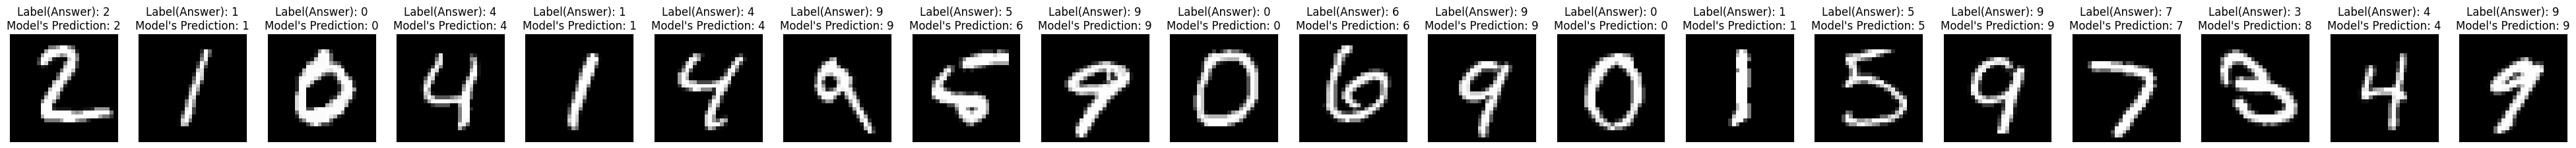

In [11]:
# modified imshowZerotoNine method
def imshowZerotoNine_modified(imgs, labels, predicted_labels=None):
    fig, axs = plt.subplots(1, len(imgs), figsize=(50, 5))
    for i, ax in enumerate(axs.flat):
        ax.imshow(imgs[i].reshape(28, 28), cmap='gray')
        title = f"Label(Answer): {labels[i]}"
        if predicted_labels is not None:
            title += f"\nModel's Prediction: {predicted_labels[i]}"
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

# Function to load models
def load_models(device):
    models = []

    for fold in range(5):
        model = Classifier()
        model.load_state_dict(torch.load(f'best_w_{fold}.pth', map_location = device))
        model.to(device)
        model.eval() # 평가 모드 전환
        models.append(model)

    return models

# Load Test Data
df_test = pd.read_csv('./sample_data/mnist_test.csv')
test_dataset = CustomDataset(df_test)
test_loader = DataLoader(test_dataset, batch_size = 20, shuffle = False)

# Load trained models
models = load_models(device)

# Perform predictions and visualize results
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.numpy()
        predictions = np.zeros((imgs.size(0), 10))

        for model in models:
            outputs = model(imgs)
            predictions += outputs.cpu().numpy()

        predicted_labels = np.argmax(predictions, axis=1)
        imshowZerotoNine_modified(imgs.cpu().numpy(), labels, predicted_labels)
        plt.show()
        break  # Remove this line if anyone want to process the entire test set